# T009 · Ligand-based pharmacophores

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Pratik Dhakal, CADD seminar, 2017, Charité/FU Berlin
- Florian Gusewski, CADD seminar, 2018, Charité/FU Berlin
- Jaime Rodríguez-Guerra, [Volkamer lab](https://volkamerlab.org/), Charité
- Dominique Sydow, [Volkamer lab](https://volkamerlab.org/), Charité

__Talktorial T009__: This talktorial is part of the TeachOpenCADD pipeline described in the [first TeachOpenCADD paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x), comprising of talktorials T001-T010.

**Note**: Please run this notebook cell by cell. Running all cells in one is possible also, however, part of the nglview 3D representations might be missing.

## Aim of this talktorial

In this talktorial, we use known EGFR ligands, which were selected and aligned in the previous talktorial, to identify donor, acceptor, and hydrophobic pharmacophoric features for each ligand. Those features are then clustered to define an ensemble pharmacophore, which represents the properties of the set of known EGFR ligands and can be used to search for novel EGFR ligands via virtual screening.

## Learning goals

### Contents in *Theory*

* Pharmacophore modeling
  * Structure- and ligand-based pharmacophore modeling
* Virtual screening with pharmacophores
* Clustering: k-means

### Contents in *Practical*

* Get pre-aligned ligands from previous talktorial
* Show ligands with NGLView
* Extract pharmacophore features
* Show the pharmacophore features of all ligands
  * Hydrogen bond donors
  * Hydrogen bond acceptors
  * Hydrophobic contacts
* Collect coordinates of features per feature type
* Generate ensemble pharmacophores
  * Set static parameters for k-means clustering
  * Set static parameters for cluster selection
  * Define k-means clustering and cluster selection functions
  * Cluster features
  * Select relevant clusters
  * Get selected cluster coordinates
* Show clusters
  * Hydrogen bond donors
  * Hydrogen bond acceptors
  * Hydrophobic contacts
* Show ensemble pharmacophore

### References

* IUPAC pharmacophore definition 
([<i>Pure & Appl. Chem</i> (1998), <b>70</b>, 1129-43](https://www.degruyter.com/view/journals/pac/70/5/article-p1129.xml))
* 3D pharmacophores in LigandScout 
([<i>J. Chem. Inf. Model.</i> (2005), <b>45</b>, 160-9](https://pubs.acs.org/doi/10.1021/ci049885e))
* Book chapter: Pharmacophore Perception and Applications 
([Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 259-82](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6f))
* Book chapter: Structure-Based Virtual Screening ([Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 313-31](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6h)).
* Monty Kier and the origin of the pharmacophore concept 
([<i>Internet Electron. J. Mol. Des.</i> (2007), <b>6</b>, 271-9](http://biochempress.com/Files/iejmd_2007_6_0271.pdf))
* Nik Stiefl's demonstration of pharmacophore modeling with RDKit 
([RDKit UGM 2016 on GitHub](https://github.com/rdkit/UGM_2016/blob/master/Notebooks/Stiefl_RDKitPh4FullPublication.ipynb)) 

## Theory

### Pharmacophores

In computer-aided drug design, the description of drug-target interactions with pharmacophores is a well-established method. The term pharmacophore was defined in 1998 by a IUPAC working party:
"A pharmacophore is the ensemble of steric and electronic features that is necessary to ensure the optimal supramolecular interactions with a specific biological target structure and to trigger (or to block) its biological response." 
([<i>Pure & Appl. Chem.</i> (1998), <b>70</b>, 1129-43](https://www.degruyter.com/view/journals/pac/70/5/article-p1129.xml))

In other words, a *pharmacophore* consists of several *pharmacophoric features*, which describe important steric and physico-chemical properties of a ligand observed to bind a target under investigation. 
Such *physico-chemical properties* (also called feature types) can be hydrogen bond donors/acceptors, hydrophobic/aromatic interactions, or positively/negatively charged groups, and the *steric properties* are defined by the 3D arrangement of these features.

### Structure- and ligand-based pharmacophore modeling

In pharmacophore modeling, two main approaches are used, depending on the biological question and available data sources, i.e. structure- and ligand-based pharmacophore modeling.

*Structure-based pharmacophore models* are derived from protein-ligand complexes. Features are defined by observed interactions between the protein and ligand, ensuring that only those ligand moieties are used for virtual screening that have already been shown to be involved in ligand binding. 
However, structures of protein-ligand complexes are not available for all targets. 
In this case, either complex structures can be generated by modeling the ligand into the target binding site, e.g. via molecular docking, or pharmacophore modeling methods can be invoked that only use the target binding site to detect potential protein-ligand interaction sites.

*Ligand-based pharmacophore models* are based on a set of ligands known to bind the target under investigation. The common chemical features of these ligands build the pharmacophore model. This method is used for targets with multiple known ligands and in case of missing protein-ligand complex structures. In this talktorial, we will use ligand-based pharmacophore modeling using a set of known EGFR ligands.

For more information on pharmacophore modeling, we recommend [Pharmacophore Perception and Applications: Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 259-82](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6f) and [<i>J. Chem. Inf. Model.</i> (2005), <b>45</b>, 160-9](https://pubs.acs.org/doi/10.1021/ci049885e).

![Structure-based pharmacophore representing protein-ligand interactions (figure by Dominique Sydow)](images/target+ligand+pharma_3x_feather.png)

*Figure 1*: Structure-based pharmacophore representing protein-ligand interactions. Figure created by Dominique Sydow.

### Virtual screening with pharmacophores

As described earlier in **Talktorial 4**, virtual screening (VS) describes the screening of a query, e.g. a pharmacophore model (T009) or a query compound (T004), against a large library of compounds, in order to identify the small molecules in the library that are most likely to bind a target under investigation (represented by the query). In pharmacophore-based virtual screening, the compound library is matched compound-by-compound into a pharmacophore model and ranked by the best matching results ([Structure-Based Virtual Screening: Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 313-31](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6h)).

### Clustering: k-means

In this talktorial we will generate an ensemble pharmacophore by clustering the feature points of several ligand-based pharmacophores. The clustering algorithm uses the k-means clustering, which aims to cluster a data set into k clusters:

1. k different centroids are selected and each point of the data set is assigned to its closest centroids.
2. New centroids are calculated based on the current clusters and each point of the data set is newly assigned to its closest centroids.
3. This procedure is repeated until the centroids are stable.

More info about [k-means in Wikipedia](https://de.wikipedia.org/wiki/K-Means-Algorithmus).

## Practical

In [100]:
import collections
from collections import Counter
from pathlib import Path
import operator
import time
import math
import json

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, cluster

from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import (
    ChemicalFeatures,
    rdDistGeom,
    Draw,
    rdMolTransforms,
    rdmolfiles,
    AllChem,
)
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
import nglview as nv

Set the Path to the current notebook.

In [4]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Get pre-aligned ligands from previous talktorial

We retrieve all ligands that were aligned in the previous talktorial.

First, we get the file paths to all ligand PDB files.

_В данном случае берем лиганды из докинга выбранных на прошлом семинаре соединений_

In [11]:
mol_file = DATA / "5ht1a-aligned-selected.sdf"
mol_file.exists()

True

Second, we read all ligands from these PDB files using RDKit.

In [15]:
# NBVAL_CHECK_OUTPUT
molecules = []

with rdmolfiles.SDMolSupplier(mol_file.as_posix()) as sdf_ligs:
    for molecule in sdf_ligs:
        if molecule is None:
            print(mol_file, "Could not be read")
        else:
            Chem.SanitizeMol(molecule)
            print(Chem.MolToSmiles(molecule))
            molecules.append(molecule)
print(f"Number of molecules: {len(molecules)}")

O=C(c1ccc(F)c(Cl)c1)N1CCC(F)(CNCCOc2ncccn2)CC1
O=C(c1ccc(F)c(Cl)c1)N1CCC(F)(CNCCOc2ccccc2Cl)CC1
O=C(c1ccc(F)c(Cl)c1)N1CCC(F)(CNCCOc2cccc3c2CCN3)CC1
O=C(c1ccc(F)c(Cl)c1)N1CCC(F)(CNCCSc2ccccn2)CC1
COc1ccccc1OCCNCC1(F)CCN(C(=O)c2ccc(F)c(Cl)c2)CC1
O=C(c1ccc(F)c(Cl)c1)N1CCC(F)(CNCCSc2ccccc2)CC1
O=C(c1ccc(Cl)c(Cl)c1)N1CCC(F)(CNCCOc2cccc3cccnc23)CC1
Number of molecules: 7


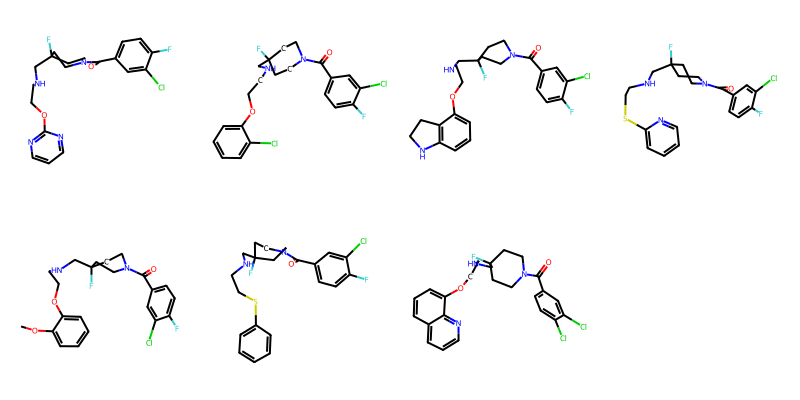

In [20]:
Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
)

Upon inspection of the structures we notice, that we encountered a problem here: When loading ligands from a PDB file, RDKit does not assign bonds in structures like aromatic rings correctly. We use the RDKit function `AssignBondOrdersFromTemplate`, which assigns bonds to a molecule based on a reference molecule, e.g. in our case based on the SMILES pattern of the molecule. 

Check for further information: [RDKit discussion on *Aromaticity of non-protein molecules in PDB not detected*](https://github.com/rdkit/rdkit/issues/1031) and [RDKit documentation](http://rdkit.org/docs/source/rdkit.Chem.AllChem.html#AssignBondOrdersFromTemplate) on `AssignBondOrdersFromTemplate`.

_У нас все в порядке, лиганды читали из `sdf`, поэтому связи какие надо. Поэтому следующая ячейка не выполняется._

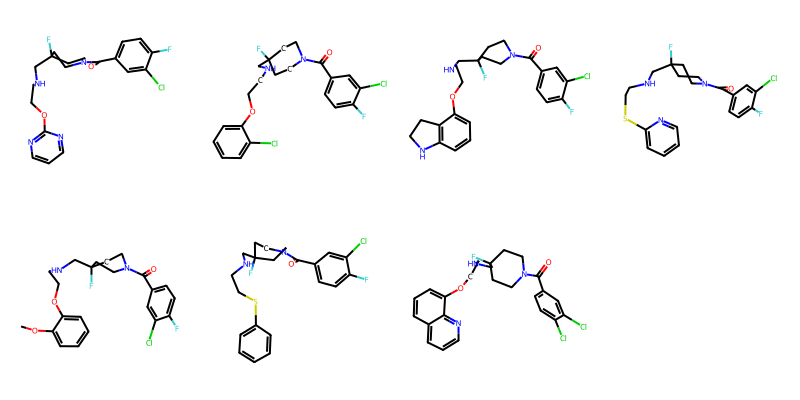

In [19]:
Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
)

Now the correct bonds are included.
We can also have a look at the molecules in 2D. In order to keep the original coordinates, we make a copy for the 2D representation.

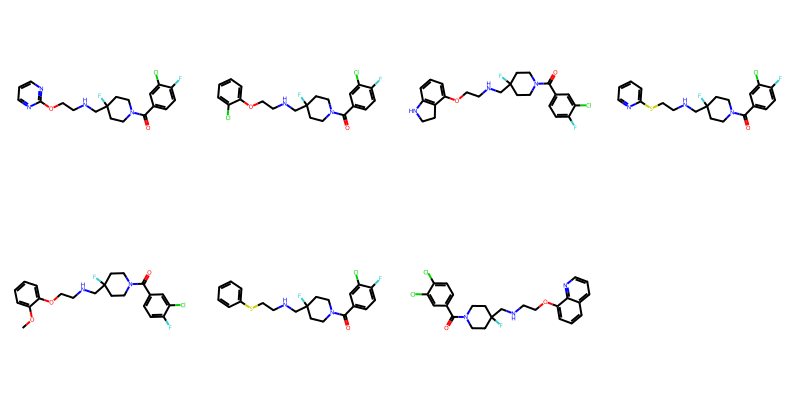

In [22]:
molecules_2d = []
for molecule in molecules:
    tmp = Chem.Mol(molecule)
    AllChem.Compute2DCoords(tmp)
    molecules_2d.append(tmp)
Draw.MolsToGridImage(
    molecules_2d,
    molsPerRow=4,
)

###  Visualize with `nglview`

In the next step we visualize the ligand molecules with nglview using the following function.
The molecules will be drawn on top of each other in a single view. This way we are able to visually compare strucural differences between the ligands.

In [23]:
def show_ligands(molecules):
    """Generate a view of the ligand molecules.

    Parameters
    -----------
    molecules: list of rdkit.Chem.rdchem.Mol

    Returns
    ----------
    nglview.widget.NGLWidget
    """
    view = nv.NGLWidget()
    for molecule in molecules:
        component = view.add_component(molecule)
        time.sleep(0.1)
        component.clear()
        component.add_ball_and_stick(multipleBond=True)
    return view

In [25]:
view = show_ligands(molecules)
view

NGLWidget()

In [27]:
view.render_image(trim=True, factor=2, transparent=True);

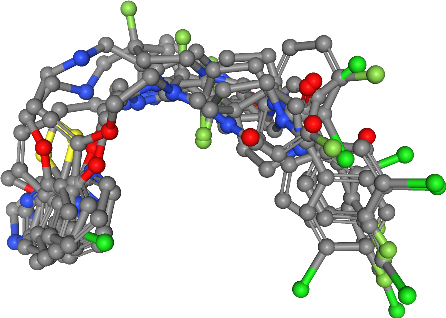

In [28]:
view._display_image()

### Extract pharmacophore features

As described above, the aim of this talktorial is to generate a ligand-based ensemble pharmacophore from a set of ligands. 
First, we need to extract pharmacophore features per ligand.
Therefore, we load a feature factory. We use the default feature definitions.

See also the [RDKit documentation on chemical features and pharmacophores](https://rdkit.readthedocs.io/en/latest/GettingStartedInPython.html#chemical-features-and-pharmacophores).

In [29]:
feature_factory = AllChem.BuildFeatureFactory(str(Path(RDConfig.RDDataDir) / "BaseFeatures.fdef"))

We take a look at the pharmacophore features that are implemented in RDKit:

In [30]:
list(feature_factory.GetFeatureDefs().keys())

['Donor.SingleAtomDonor',
 'Acceptor.SingleAtomAcceptor',
 'NegIonizable.AcidicGroup',
 'PosIonizable.BasicGroup',
 'PosIonizable.PosN',
 'PosIonizable.Imidazole',
 'PosIonizable.Guanidine',
 'ZnBinder.ZnBinder1',
 'ZnBinder.ZnBinder2',
 'ZnBinder.ZnBinder3',
 'ZnBinder.ZnBinder4',
 'ZnBinder.ZnBinder5',
 'ZnBinder.ZnBinder6',
 'Aromatic.Arom4',
 'Aromatic.Arom5',
 'Aromatic.Arom6',
 'Aromatic.Arom7',
 'Aromatic.Arom8',
 'Hydrophobe.ThreeWayAttach',
 'Hydrophobe.ChainTwoWayAttach',
 'LumpedHydrophobe.Nitro2',
 'LumpedHydrophobe.RH6_6',
 'LumpedHydrophobe.RH5_5',
 'LumpedHydrophobe.RH4_4',
 'LumpedHydrophobe.RH3_3',
 'LumpedHydrophobe.tButyl',
 'LumpedHydrophobe.iPropyl']

As an example, we extract all features from the first molecule.

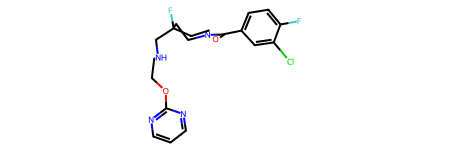

In [31]:
example_molecule = molecules[0]
example_molecule

In [32]:
# NBVAL_CHECK_OUTPUT
features = feature_factory.GetFeaturesForMol(example_molecule)
print(f"Number of features found: {len(features)}")

Number of features found: 14


The type of a feature is called family in RDKit and can be retrieved with `GetFamily()`.

In [33]:
# NBVAL_CHECK_OUTPUT
features[0].GetFamily()

'Donor'

First we get the frequency of feature types for our example molecule.

In [34]:
# NBVAL_CHECK_OUTPUT
feature_frequency = collections.Counter(sorted([feature.GetFamily() for feature in features]))
feature_frequency

Counter({'Acceptor': 6,
         'Aromatic': 2,
         'Donor': 2,
         'Hydrophobe': 2,
         'LumpedHydrophobe': 1,
         'PosIonizable': 1})

Now apply the functions shown above to all molecules in our ligand set. 
We calculate the feature type frequency per molecule, then we display it in a DataFrame.

In [35]:
molecule_feature_frequencies = []
for molecule in molecules:
    features = [feature.GetFamily() for feature in feature_factory.GetFeaturesForMol(molecule)]
    feature_frequency = collections.Counter(features)
    molecule_feature_frequencies.append(feature_frequency)

feature_frequencies_df = (
    pd.DataFrame(
        molecule_feature_frequencies,
        index=[f"Mol{i}" for i, _ in enumerate(molecules, 1)],
    )
    .fillna(0)
    .astype(int)
)
feature_frequencies_df.transpose()

,Mol1,Mol2,Mol3,Mol4,Mol5,Mol6,Mol7
Donor,2,2,3,2,2,2,2
Acceptor,6,4,4,4,5,3,4
PosIonizable,1,1,1,1,1,1,1
Aromatic,2,2,2,2,2,2,3
Hydrophobe,2,3,3,3,2,4,4
LumpedHydrophobe,1,2,2,1,2,2,2


Furtheron, we concentrate in this talktorial only on the following feature types: hydrogen bond acceptors (acceptors), hydrogen bond donors (donors), and hydrophobic contacts (hydrophobics).

We retrieve the feature RDKit objects per feature type and per molecule. 

In [36]:
acceptors = []
donors = []
hydrophobics = []

for molecule in molecules:
    acceptors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Acceptor"))
    donors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Donor"))
    hydrophobics.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Hydrophobe"))

features = {
    "donors": donors,
    "acceptors": acceptors,
    "hydrophobics": hydrophobics,
}

### Show the pharmacophore features of all ligands

Pharmacophore feature types usually are displayed in defined colors, e.g. usually hydrogen bond donors, hydrogen bond acceptors, and hydrophobic contacts are colored green, red, and yellow, respectively.

In [37]:
feature_colors = {
    "donors": (0, 0.9, 0),  # Green
    "acceptors": (0.9, 0, 0),  # Red
    "hydrophobics": (1, 0.9, 0),  # Yellow
}

In [38]:
def visualize_features(
    molecules,
    features,
    feature_type="features",
    color="yellow",
    sphere_radius=0.5,
):
    """Generate a view of the molecules highlighting the specified feature type.

    Parameters
    -----------
    molecules: list of rdkit.Chem.rdchem.Mol
        molecules to be visualized
    features: list of tuples of rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature
        extracted features from molecules chosen to be highlighted
    feature_type: string, optional
        name of the feature to be highlighted
    color: string, optional
        color used to display the highlighted features
    sphere_radius: float, optional
        display size of the highlighted features

    Returns
    ----------
    nglview.widget.NGLWidget
    """
    print(f"Number of {feature_type} in all ligands: {sum([len(i) for i in features])}")
    view = show_ligands(molecules)
    for i, feature_set in enumerate(features, 1):
        for feature in feature_set:
            loc = list(feature.GetPos())
            label = f"{feature_type}_{i}"
            view.shape.add_sphere(loc, color, sphere_radius, label)
    return view

We use this function to visualize the features for the feature types under consideration.

#### Hydrogen bond donors

In [40]:
feature_type = "donors"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of donors in all ligands: 15


NGLWidget()

In [43]:
view.render_image(trim=True, factor=2, transparent=True);

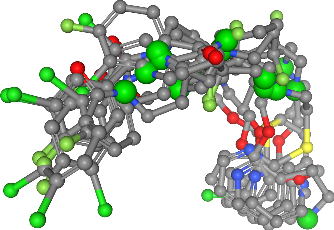

In [44]:
view._display_image()

#### Hydrogen bond acceptors

In [45]:
feature_type = "acceptors"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of acceptors in all ligands: 30


NGLWidget()

In [46]:
view.render_image(trim=True, factor=2, transparent=True);

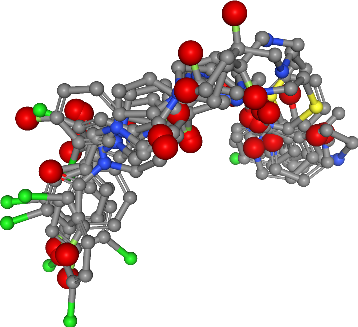

In [47]:
view._display_image()

#### Hydrophobic contacts

In [48]:
feature_type = "hydrophobics"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of hydrophobics in all ligands: 21


NGLWidget()

In [49]:
view.render_image(trim=True, factor=2, transparent=True);

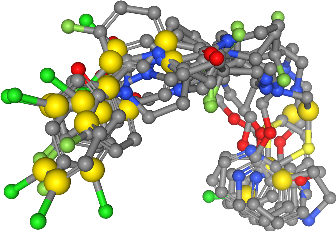

In [50]:
view._display_image()

### Collect coordinates of features per feature type

We want to cluster features per feature type. To do this we collect all coordinates of features and store them per feature type. 

In [51]:
features_coord = {
    "donors": [list(item.GetPos()) for sublist in features["donors"] for item in sublist],
    "acceptors": [list(item.GetPos()) for sublist in features["acceptors"] for item in sublist],
    "hydrophobics": [
        list(item.GetPos()) for sublist in features["hydrophobics"] for item in sublist
    ],
}

Now, we have the positions of e.g. all acceptor features:

In [52]:
features_coord["acceptors"]

[[98.723, 120.548, 110.707],
 [104.635, 121.819, 112.128],
 [95.54, 122.566, 115.03],
 [95.208, 116.88, 116.973],
 [94.177, 114.857, 116.251],
 [96.451, 115.259, 115.894],
 [102.824, 121.191, 112.864],
 [105.427, 116.356, 109.93],
 [97.5, 121.465, 112.081],
 [97.036, 116.744, 116.021],
 [102.674, 120.975, 112.888],
 [105.216, 116.154, 109.666],
 [98.695, 118.715, 112.875],
 [96.224, 117.299, 115.622],
 [101.974, 118.85, 114.338],
 [104.219, 116.956, 108.786],
 [97.452, 121.978, 113.868],
 [96.689, 116.492, 115.843],
 [94.405, 115.157, 115.828],
 [95.872, 117.333, 115.246],
 [98.658, 118.511, 112.768],
 [103.337, 119.775, 113.035],
 [105.107, 115.3, 109.045],
 [98.521, 120.341, 110.302],
 [104.183, 119.142, 112.866],
 [95.485, 119.635, 113.289],
 [104.048, 119.93, 110.724],
 [98.409, 120.337, 112.355],
 [97.443, 117.974, 116.198],
 [97.275, 115.349, 115.554]]

### Generate ensemble pharmacophores

In order to generate ensemble pharmacophores, we use k-means clustering to cluster features per feature type.

#### Set static parameters for k-means clustering

* `kq`: With this paramter, we determine the number of clusters `k` per feature type depending on the number of feature points, i.e. per feature type 
* `k` = number_of_features / `kq` 
* `kq` should be selected so that `k` (feature clusters) is for all clusters at least 1 and not larger than 4-5 clusters 

We set our `kq` used to determine `k` in k-means as follows:

In [53]:
kq = 7

#### Set static parameters for cluster selection

* `min_cluster_size`: We only want to retain clusters that potentially contain features from most molecules in our ligand ensemble. Therefore, we set this variable to 75% of the number of molecules in our ligand ensemble. 
* `top_cluster_number`: With this parameter, we select only the largest clusters. 

In [54]:
min_cluster_size = int(len(molecules) * 0.75)
top_cluster_number = 4

#### Define k-means clustering and cluster selection functions

We define a function that calculates the centers of clusters, which are derived from k-means clustering.

In [55]:
def clustering(feature_coord, kq):
    """
    Compute the k-means clustering of input feature coordinates.

    Parameters
    -----------
    feature_coord: list
        feature coordinates extracted from the features of a set of molecules
    kq: int
        Quotient used when calculating number of features k

    Returns
    ----------
    sklearn.cluster._kmeans.KMeans
    """
    # Define parameter k as feature number divided by "k quotient"
    k = math.ceil(len(feature_coord) / kq)
    # Tailor-made adaption of k for hydrophobics in for the example in this talktorial
    k = 2 if k == 1 else k
    print(f"Clustering: \nVariable k in k-means: {k} of {len(feature_coord)} points\n")

    # Initialize k-means and compute clustering
    k_means = cluster.KMeans(n_clusters=k, n_init=10)
    k_means.fit(feature_coord)

    return k_means

We define a function that sorts the clusters by size and outputs a list of indices of the largest clusters.

In [56]:
def get_clusters(k_means, min_cluster_size, top_cluster_number):
    """
    Select clusters from a k-means clustering and returns the indices of the selected clusters.
    The selection is based on cluster size. The largest clusters are chosen.

    Parameters
    -----------
    k_means: sklearn.cluster._kmeans.KMeans
        k-means clustering of feature coordinates
    min_cluster_size: int
        minimum size needed for a cluster to be viable for selection
    top_cluster_number: int
        number of clusters to be selected

    Returns
    ----------
    list of int
        indices of selected clusters
    """

    # Sort clusters by size and only show largest
    feature_labels = k_means.labels_

    feature_labels_count = Counter(feature_labels)

    feature_labels_count = sorted(
        feature_labels_count.items(), key=operator.itemgetter(1), reverse=True
    )
    print(f"Clusters sorted by size: \n{feature_labels_count}\n")

    # Get number of the largest clusters, which are larger then the threshold (selected clusters)
    cluster_indices_sel = []

    for cluster_index, cluster_size in feature_labels_count:
        if cluster_size >= min_cluster_size and top_cluster_number > 0:
            cluster_indices_sel.append(cluster_index)
            top_cluster_number -= 1

    print(f"Cluster indices of selected clusters: \n{cluster_indices_sel}\n")

    return cluster_indices_sel

#### Cluster features

For each feature type, we perform the k-means clustering with our defined `clustering` function.

In [57]:
k_means = {
    "donors": clustering(features_coord["donors"], kq),
    "acceptors": clustering(features_coord["acceptors"], kq),
    "hydrophobics": clustering(features_coord["hydrophobics"], kq),
}

Clustering: 
Variable k in k-means: 3 of 15 points

Clustering: 
Variable k in k-means: 5 of 30 points

Clustering: 
Variable k in k-means: 3 of 21 points



#### Select relevant clusters

For each feature type, we select relevant clusters with our defined `get_clusters` function.

In [58]:
print("Hydrogen bond donors\n")
cluster_indices_sel_donors = get_clusters(k_means["donors"], min_cluster_size, top_cluster_number)

Hydrogen bond donors

Clusters sorted by size: 
[(0, 9), (1, 5), (2, 1)]

Cluster indices of selected clusters: 
[0, 1]



In [59]:
print("Hydrogen bond acceptors\n")
cluster_indices_sel_acceptors = get_clusters(
    k_means["acceptors"], min_cluster_size, top_cluster_number
)

Hydrogen bond acceptors

Clusters sorted by size: 
[(1, 10), (0, 7), (4, 5), (3, 4), (2, 4)]

Cluster indices of selected clusters: 
[1, 0, 4]



In [60]:
print("Hydrophobic contacts\n")
cluster_indices_sel_hydrophobic = get_clusters(
    k_means["hydrophobics"], min_cluster_size, top_cluster_number
)

Hydrophobic contacts

Clusters sorted by size: 
[(1, 8), (2, 7), (0, 6)]

Cluster indices of selected clusters: 
[1, 2, 0]



In [61]:
cluster_indices_sel = {
    "donors": cluster_indices_sel_donors,
    "acceptors": cluster_indices_sel_acceptors,
    "hydrophobics": cluster_indices_sel_hydrophobic,
}

#### Get selected cluster coordinates

In [62]:
def get_selected_cluster_center_coords(k_means, cluster_indices_sel):
    """Retrieve cluster center coordinates for selected clusters.
    The selected clusters are defined by their indices.

    Parameters
    -----------
    k_means: sklearn.cluster._kmeans.KMeans
        k-means clustering of feature coordinates
    cluster_indices_sel: list of int
        indices of the chosen clusters

    Returns
    ----------
    two-dimensional list of floats
        cluster center coordinates
    """
    cluster_centers = k_means.cluster_centers_

    # Cast to list and then to pandas Series (for element selection by indices)
    cluster_centers = pd.Series(cluster_centers.tolist())

    # Select cluster centers by indices of selected clusters
    cluster_centers_sel = cluster_centers[cluster_indices_sel]

    return list(cluster_centers_sel)

In [63]:
cluster_centers_sel = {
    "donors": get_selected_cluster_center_coords(k_means["donors"], cluster_indices_sel["donors"]),
    "acceptors": get_selected_cluster_center_coords(
        k_means["acceptors"], cluster_indices_sel["acceptors"]
    ),
    "hydrophobics": get_selected_cluster_center_coords(
        k_means["hydrophobics"], cluster_indices_sel["hydrophobics"]
    ),
}

_Добавим экспорт фичей в виде json, который может прочитать, например, [ZincPharmer](http://zincpharmer.csb.pitt.edu/pharmer.html)_

In [112]:
def make_pharmer_query(cluster_centers):
    feature_names = {
        "donors": "HydrogenDonor",
        "acceptors": "HydrogenAcceptor",
        "hydrophobics": "Hydrophobic"
    }

    features = {
        "points": [],
    }

    for cluster_type in cluster_centers_sel:
        for xyz in cluster_centers_sel[cluster_type]:
            point = {
                "radius": 1,
                "requirement": "required",
                "size": 6,
                "enabled": True,
                "svector": None,
                "minsize": "",
                "maxsize": ""
            }
            point["name"] = feature_names[cluster_type]
            for dim, val in zip("xyz", xyz):
                point[dim] = val
            features["points"].append(point)
    return features

In [113]:
with (DATA/"features.json").open("w") as features:
    json.dump(
        make_pharmer_query(
            cluster_centers_sel,
        ),
        features,
        indent=2
    )

### Show clusters

Per feature type, we visualize cluster centers alongside with all molecules and all feature points. 

In [90]:
def visualize_clusters(
    molecules,
    features,
    clusters,
    feature_type="features",
    color="yellow",
    feature_radius=0.5,
    cluster_radius=1,
):
    """Visualize the cluster centers.

    Parameters
    -----------
     molecules: list of rdkit.Chem.rdchem.Mol
        molecules to be visualized
    features: list of tuples of rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature
        extracted features from molecules chosen to be highlighted
    clusters: Two-dimensional list of floats
        cluster center coordinates
    feature_type: string, optional
        feature type being visualized
    color: string, optional
        color used for rendering the features and cluster centers
    feature_radius: float, optional
        rendering size of the features
    cluster_radius: float, optional
        rendering size of the cluster centers

    Returns
    ----------
    nglview.widget.NGLWidget
    """
    view = visualize_features(
        molecules,
        features,
        feature_type,
        color=color,
        sphere_radius=feature_radius,
    )
    for i, center in enumerate(clusters, 1):
        view.shape.add_sphere(list(center), color, cluster_radius, f"cluster_{feature_type}_{i}")
    return view

#### Hydrogen bond donors

In [91]:
feature_type = "donors"
view = visualize_clusters(
    molecules,
    features[feature_type],
    cluster_centers_sel[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of donors in all ligands: 15


NGLWidget()

In [68]:
view.render_image(trim=True, factor=2, transparent=True);

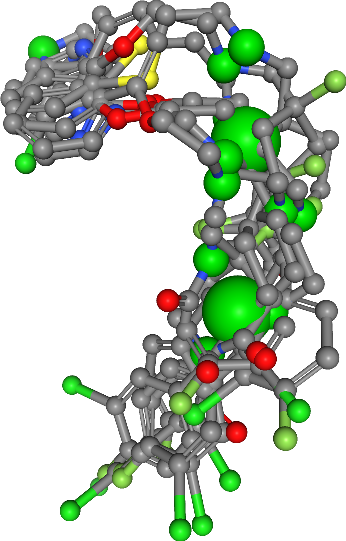

In [69]:
view._display_image()

#### Hydrogen bond acceptor

In [70]:
feature_type = "acceptors"
view = visualize_clusters(
    molecules,
    features[feature_type],
    cluster_centers_sel[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of acceptors in all ligands: 30


NGLWidget()

In [73]:
view.render_image(trim=True, factor=2, transparent=True);

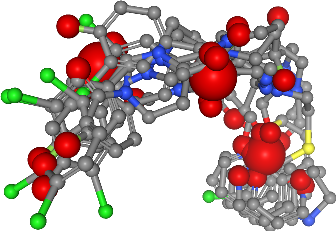

In [74]:
view._display_image()

#### Hydrophobic contacts

In [75]:
feature_type = "hydrophobics"
view = visualize_clusters(
    molecules,
    features[feature_type],
    cluster_centers_sel[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of hydrophobics in all ligands: 21


NGLWidget()

In [76]:
view.render_image(trim=True, factor=2, transparent=True);

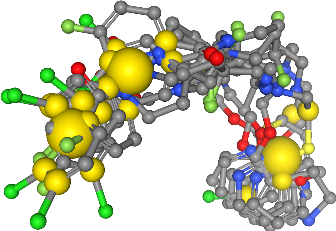

In [77]:
view._display_image()

### Show ensemble pharmacophore

In this last step, we combine the clustered pharmacophoric features (i.e. hydrogen bond donors and acceptors as well as hydrophobic contacts), to one ensemble pharmacophore, representing the pharmacophoric properties of the four selected ligands.

In [92]:
view = show_ligands(molecules)
# Load clusters
for feature_type in cluster_indices_sel:
    centers = cluster_centers_sel[feature_type]
    for i, loc in enumerate(centers):
        sphere_radius = 1
        feature_color = feature_colors[feature_type]
        label = f"{feature_type}_c{i}"
        view.shape.add_sphere(loc, feature_color, sphere_radius, label)
view

NGLWidget()

In [79]:
view.render_image(trim=True, factor=2, transparent=True);

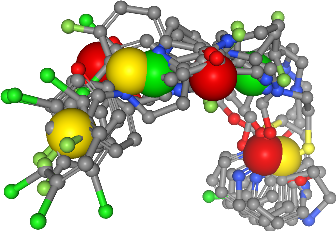

In [80]:
view._display_image()

## Discussion

In this talktorial, we used a set of pre-aligned ligands, which are known to bind EGFR, to generate an ensemble pharmacophore model. This model could now be used for virtual screening against a large library of small molecules, in order to find novel small molecules that show the observed steric and physico-chemical properties and might therefore also bind to the EGFR binding site. 

Before screening, the pharmacophore models are usually further optimized, e.g. features might be omitted in order to reduce the number of features for screening based on biological knowledge (some interaction might be reported as important whereas others are not) or based on chemical expertise.

We do not cover the virtual screening in this talktorial, however refer to an excellent tutorial by Nik Stiefl, demonstrating pharmacophore modeling and virtual screening with RDKit ([RDKit UGM 2016 on GitHub](https://github.com/rdkit/UGM_2016/blob/master/Notebooks/Stiefl_RDKitPh4FullPublication.ipynb)).

We used k-means clustering to cluster pharmacophore feature. This clustering approach has the disadvantage that the user needs to define the number of clusters beforehand, which is usually based on a visual inspection of the point distribution before clustering (or during cluster refinement) and is therefore hindering for an automated pharmacophore generation. Density-based clustering methods, also in combination with k-means clustering, can be a solution for this. For further reading we recommend the [introduction to Density-Based Clustering at Domino Data Lab](https://blog.dominodatalab.com/topology-and-density-based-clustering/).

## Quiz

1. Explain the terms pharmacophoric features and pharmacophore.
2. Explain the difference between structure- and ligand-based pharmacophore modeling.
3. Explain how we derived an ensemble pharmacophore.